# Linear Regression from Scratch: Bank Marketing Dataset

This notebook implements a linear regression model from scratch on the `bank-additional-full.csv` dataset.

**Important Note:** This dataset's primary target variable, `y` ('yes'/'no'), is categorical. This makes the original problem a **classification** task, not a regression task. 

To fulfill the request of applying **Linear Regression**, we will select a *continuous* variable from the dataset to be our target. We will attempt to **predict the `duration` of the last call** based on all other client and socio-economic features.

**Steps we will follow:**
1.  **Import Libraries:** `numpy`, `pandas`, `matplotlib`, `seaborn`.
2.  **Load Data:** Read the `bank-additional-full.csv` file (note the `;` delimiter).
3.  **EDA & Cleaning:** Explore the data, check for nulls, and analyze our new target, `duration`.
4.  **Preprocessing:** This is more complex. We must:
    * Handle many categorical features using **One-Hot Encoding**.
    * Scale all numerical features.
    * Split into training and testing sets.
5.  **Build Model:** We will *reuse* the `LinearRegressionScratch` class (as it's generic).
6.  **Train Model:** Use gradient descent.
7.  **Evaluate Model:** Check MSE and R-squared.
8.  **Hypothesis Testing:** Check the statistical significance of the model (F-test) and its coefficients (t-test).
9.  **Visualize Results:** Plot predictions vs. actual values.

### Step 1: Import Libraries

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats # Added for hypothesis testing

%matplotlib inline

# Set plot style
sns.set(style='whitegrid', context='talk')

### Step 2: Load Data

In [16]:
# Load the dataset. Note the delimiter is a semicolon ';'
try:
    df = pd.read_csv('bank-additional-full.csv', delimiter=';')
    print("File loaded successfully!")
except FileNotFoundError:
    print("Error: bank-additional-full.csv not found. Please make sure the file is in the same directory.")
    df = pd.DataFrame()

if not df.empty:
    print("Data Head:")
    print(df.head())

File loaded successfully!
Data Head:
   age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week  ...  campaign  pdays  previous     poutcome emp.var.rate  \
0   may         mon  ...         1    999         0  nonexistent          1.1   
1   may         mon  ...         1    999         0  nonexistent          1.1   
2   may         mon  ...         1    999         0  nonexistent          1.1   
3   may         mon  ...         1    999         0  nonexistent          1.1   
4   may         mon  ...         1    999         0  nonexistent          1.1   

   cons.price.idx  

In [17]:
# Use a random sample of 5000 rows
df = df.sample(5000, random_state=42)
print(f"Using a smaller sample of {len(df)} rows to run faster.")

Using a smaller sample of 5000 rows to run faster.


### Step 3: Exploratory Data Analysis (EDA) & Cleaning

In [18]:
if not df.empty:
    # Get a summary of the data
    print("\nData Info:")
    df.info()
    # We have many 'object' columns (categorical) and several 'float64'/'int64' (numerical).


Data Info:
<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 32884 to 24082
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             5000 non-null   int64  
 1   job             5000 non-null   object 
 2   marital         5000 non-null   object 
 3   education       5000 non-null   object 
 4   default         5000 non-null   object 
 5   housing         5000 non-null   object 
 6   loan            5000 non-null   object 
 7   contact         5000 non-null   object 
 8   month           5000 non-null   object 
 9   day_of_week     5000 non-null   object 
 10  duration        5000 non-null   int64  
 11  campaign        5000 non-null   int64  
 12  pdays           5000 non-null   int64  
 13  previous        5000 non-null   int64  
 14  poutcome        5000 non-null   object 
 15  emp.var.rate    5000 non-null   float64
 16  cons.price.idx  5000 non-null   float64
 17  cons.conf.idx   5000 

In [19]:
if not df.empty:
    # Statistical summary for numerical features
    print("\nNumerical Data Description:")
    print(df.describe())


Numerical Data Description:
               age     duration     campaign        pdays     previous  \
count  5000.000000  5000.000000  5000.000000  5000.000000  5000.000000   
mean     39.988400   260.168000     2.533600   960.469000     0.168000   
std      10.309681   254.283423     2.688999   191.799732     0.496614   
min      17.000000     2.000000     1.000000     0.000000     0.000000   
25%      32.000000   102.000000     1.000000   999.000000     0.000000   
50%      38.000000   180.000000     2.000000   999.000000     0.000000   
75%      47.000000   323.000000     3.000000   999.000000     0.000000   
max      88.000000  2420.000000    42.000000   999.000000     6.000000   

       emp.var.rate  cons.price.idx  cons.conf.idx    euribor3m  nr.employed  
count   5000.000000     5000.000000    5000.000000  5000.000000  5000.000000  
mean       0.092960       93.576133     -40.434560     3.638883  5167.609800  
std        1.565502        0.577694       4.649358     1.726349    

In [20]:
if not df.empty:
    # Summary for categorical features
    print("\nCategorical Data Description:")
    print(df.describe(include='object'))


Categorical Data Description:
           job  marital          education default housing  loan   contact  \
count     5000     5000               5000    5000    5000  5000      5000   
unique      12        4                  8       2       3     3         2   
top     admin.  married  university.degree      no     yes    no  cellular   
freq      1264     3077               1433    3948    2632  4066      3145   

       month day_of_week     poutcome     y  
count   5000        5000         5000  5000  
unique    10           5            3     2  
top      may         thu  nonexistent    no  
freq    1698        1062         4345  4438  


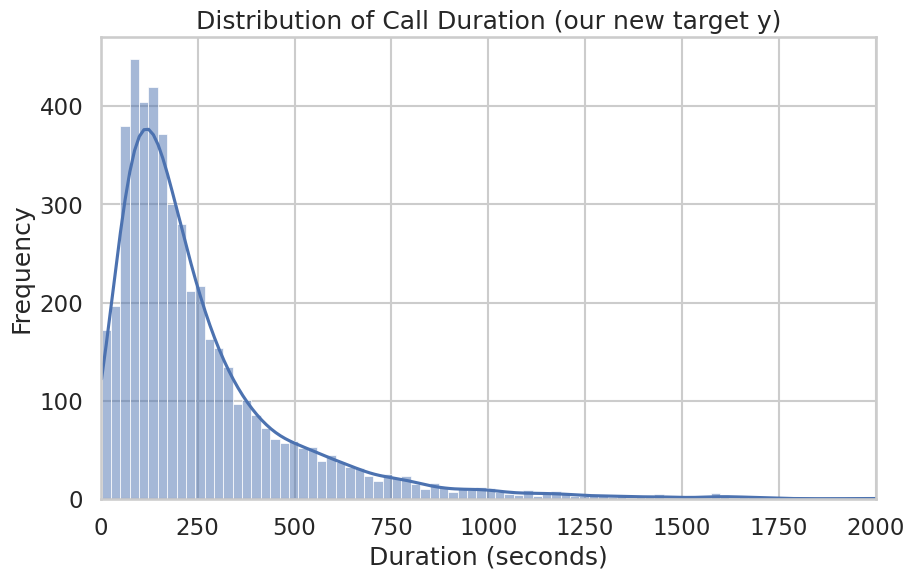

In [21]:
if not df.empty:
    # As decided, 'duration' is our new target variable.
    # Let's visualize its distribution.
    plt.figure(figsize=(10, 6))
    sns.histplot(df['duration'], bins=100, kde=True)
    plt.title('Distribution of Call Duration (our new target y)')
    plt.xlabel('Duration (seconds)')
    plt.ylabel('Frequency')
    plt.xlim(0, 2000) # Zoom in to see the main distribution
    plt.show()
    
    # The data is heavily skewed to the right. Most calls are short.

### Step 4: Data Preprocessing

This is the most complex step for this dataset.
1.  **Define Target (y) and Features (X):**
    * `y = df['duration']`
    * `X` = everything else. We must drop `y` (the original classification target) as well, since it's a result of the call, not a predictor *of* its duration.
2.  **Separate Numerical and Categorical Features:** We need to treat them differently.
3.  **One-Hot Encode Categorical Features:** Convert columns like `job`, `marital`, etc., into numerical 0/1 columns.
4.  **Scale Numerical Features:** Standardize all numerical columns (e.g., `age`, `campaign`).
5.  **Combine:** Re-combine the scaled numerical and encoded categorical features.
6.  **Add Bias Term:** Add a column of ones.
7.  **Train-Test Split:** Split the final processed data.

In [22]:
def preprocess_bank_data(df, target_col, test_size=0.2):
    """Prepares the complex bank data for the model."""
    if df.empty:
        return None, None, None, None, None
    
    # 1. Define Target (y) and Features (X)
    y = df[target_col].values
    # Drop the original 'y' and our new target 'duration'
    X = df.drop([target_col, 'y'], axis=1)
    
    # 2. Separate Numerical and Categorical Features
    X_num = X.select_dtypes(include=['int64', 'float64'])
    X_cat = X.select_dtypes(include=['object'])
    
    # 3. One-Hot Encode Categorical Features
    # drop_first=True helps reduce multicollinearity
    X_cat_encoded = pd.get_dummies(X_cat, drop_first=True)
    
    # 4. Scale Numerical Features (Standardization)
    X_num_mean = X_num.mean()
    X_num_std = X_num.std()
    X_num_scaled = (X_num - X_num_mean) / X_num_std
    
    # 5. Combine processed features
    # Reset index to ensure they align perfectly
    X_processed = pd.concat([
        X_num_scaled.reset_index(drop=True),
        X_cat_encoded.reset_index(drop=True)
    ], axis=1)
    
    # Get feature names before adding bias
    feature_names = ['Intercept'] + list(X_processed.columns)
    
    X_processed_np = X_processed.values
    
    # 6. Add Bias Term
    X_final = np.hstack((np.ones((X_processed_np.shape[0], 1)), X_processed_np))
    
    # 7. Train-Test Split
    indices = np.arange(X_final.shape[0])
    np.random.shuffle(indices)
    
    X_final = X_final[indices]
    y = y[indices]
    
    split_index = int((1 - test_size) * X_final.shape[0])
    
    X_train = X_final[:split_index]
    y_train = y[:split_index]
    X_test = X_final[split_index:]
    y_test = y[split_index:]
    
    return X_train, y_train, X_test, y_test, feature_names

In [23]:
if not df.empty:
    # Set a random seed for reproducibility
    np.random.seed(42)
    
    X_train, y_train, X_test, y_test, feature_names = preprocess_bank_data(df, target_col='duration', test_size=0.2)
    
    print(f"X_train shape: {X_train.shape}") # Note the high number of features!
    print(f"y_train shape: {y_train.shape}")
    print(f"X_test shape: {X_test.shape}")
    print(f"y_test shape: {y_test.shape}")
    
    print(f"\nFeature Names (Total: {len(feature_names)}):")
    # print(feature_names) # Commented out, as the list is very long
    
    # We now have 53 features (1 bias + 9 numerical + 43 from one-hot encoding)

X_train shape: (4000, 52)
y_train shape: (4000,)
X_test shape: (1000, 52)
y_test shape: (1000,)

Feature Names (Total: 52):


### Step 5: Build Linear Regression Model (from scratch)

We can reuse the *exact same* class and evaluation functions from the Boston housing notebook. This is the power of building generic, class-based models!

In [24]:
class LinearRegressionScratch:
    """Linear Regression model implementation from scratch using Gradient Descent."""
    
    def __init__(self, learning_rate=0.01, n_iterations=1000):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.theta = None  # This will store our weights (including bias)
        self.cost_history = [] # To visualize learning

    def fit(self, X, y):
        """Trains the model using Gradient Descent."""
        m_samples, n_features = X.shape
        self.theta = np.zeros(n_features)
        self.cost_history = []
        
        for i in range(self.n_iterations):
            y_pred = np.dot(X, self.theta)
            error = y_pred - y
            gradient = (1 / m_samples) * np.dot(X.T, error)
            self.theta = self.theta - self.learning_rate * gradient
            
            cost = self.compute_cost(X, y, y_pred)
            self.cost_history.append(cost)
            
            if (i % 200) == 0:
                print(f"Iteration {i}: Cost = {cost:.2f}")
        
        print("Model training complete.")

    def predict(self, X):
        """Makes predictions for new data X."""
        if self.theta is None:
            raise Exception("Model not trained yet. Call fit() first.")
        return np.dot(X, self.theta)

    def compute_cost(self, X, y, y_pred):
        """Calculates the Mean Squared Error cost."""
        m_samples = X.shape[0]
        cost = (1 / (2 * m_samples)) * np.sum((y_pred - y)**2)
        return cost

# --- Evaluation Functions ---

def mean_squared_error(y_true, y_pred):
    """Calculates Mean Squared Error from scratch."""
    return np.mean((y_true - y_pred)**2)

def r2_score(y_true, y_pred):
    """Calculates R-squared (Coefficient of Determination) from scratch."""
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    if ss_tot == 0:
        return 1.0 if ss_res == 0 else 0.0
    return 1 - (ss_res / ss_tot)

### Step 6: Train & Evaluate Model

This model has many features (53), so it may require more iterations or a different learning rate to converge well. We'll start with our previous settings and see.

In [25]:
if 'X_train' in locals():
    # --- Train the Model ---
    
    # Hyperparameters
    # We need a smaller learning rate and more iterations due to 
    # the high dimensionality (many features).
    learning_rate = 0.005
    n_iterations = 2000

    model = LinearRegressionScratch(learning_rate=learning_rate, n_iterations=n_iterations)
    model.fit(X_train, y_train)
    
    # --- Evaluate the Model (on Training Data) ---
    y_pred_train = model.predict(X_train)
    mse_train = mean_squared_error(y_train, y_pred_train)
    r2_train = r2_score(y_train, y_pred_train)
    
    print("\n--- Model Evaluation (on Training Data) ---")
    print(f"Training Mean Squared Error (MSE): {mse_train:.2f}")
    print(f"Training R-squared (R²): {r2_train:.4f}")

    # --- Evaluate the Model (on Test Data) ---
    y_pred_test = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred_test)
    r2 = r2_score(y_test, y_pred_test)
    
    print("\n--- Model Evaluation (on Test Data) ---")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"R-squared (R²): {r2:.4f}")
else:
    print("Data not loaded, skipping model training.")


Iteration 0: Cost = 64263.70
Iteration 200: Cost = 31501.97
Iteration 400: Cost = 31227.59
Iteration 600: Cost = 31094.24
Iteration 800: Cost = 31004.94
Iteration 1000: Cost = 30941.19
Iteration 1200: Cost = 30893.84
Iteration 1400: Cost = 30857.46
Iteration 1600: Cost = 30828.61
Iteration 1800: Cost = 30805.04
Model training complete.

--- Model Evaluation (on Training Data) ---
Training Mean Squared Error (MSE): 61570.51
Training R-squared (R²): 0.0114

--- Model Evaluation (on Test Data) ---
Mean Squared Error (MSE): 74946.38
R-squared (R²): -0.0135


### Step 7: Hypothesis Testing

Now we'll conduct hypothesis tests to check:
1.  **Overall Model Significance (F-test):**
    * $H_0$: All coefficients are zero (model is useless).
    * $H_a$: At least one coefficient is non-zero (model has predictive power).
2.  **Individual Coefficient Significance (t-test):**
    * $H_0$: $\theta_j = 0$ (feature *j* is not significant).
    * $H_a$: $\theta_j \neq 0$ (feature *j* is significant).

We will perform these calculations from scratch using our trained model and training data.

In [27]:
def perform_hypothesis_tests(model, X, y, feature_names):
    """Calculates t-statistics and F-statistic for the trained model."""
    
    print("--- Starting Hypothesis Tests ---")

    # --- FIX: Check and convert X's dtype --- 
    # The error "Cannot cast ufunc 'inv' input from dtype('O')" 
    # means X is 'object' type. We must force it to float64.
    if X.dtype == 'object':
        print("Warning: X dtype is 'object'. Forcing to 'float64'.")
        try:
            X = X.astype(np.float64)
        except ValueError as e:
            print(f"FATAL ERROR: Could not convert X to float. Error: {e}")
            print("This suggests a major problem in the preprocessing step.")
            return
    
    y_pred = model.predict(X)
    n_samples, n_features = X.shape # n = samples, p = features (incl. intercept)
    
    # --- T-Tests for Individual Coefficients ---
    
    # 1. Calculate residuals
    residuals = y - y_pred
    
    # 2. Calculate residual sum of squares (RSS or SS_res)
    ss_res = np.sum(residuals**2)
    
    # 3. Calculate residual standard error (RSE) or sigma_hat^2
    df_residual = n_samples - n_features

    # --- ROBUSTNESS FIX: Check for df_residual <= 0 ---
    if df_residual <= 0:
        print(f"Error: Degrees of freedom for residual is {df_residual}.")
        print("This means n_samples <= n_features. Cannot calculate t-stats or F-stat.")
        print(f"(n_samples={n_samples}, n_features={n_features})")
        return
        
    sigma_squared = ss_res / df_residual
    
    # 4. Calculate the covariance matrix of parameters
    # Var(theta) = sigma^2 * (X.T @ X)^-1
    try:
        # Adding a small identity matrix (ridge regression) 
        # to stabilize the inverse calculation, as high multicollinearity is likely
        identity_matrix = np.eye(n_features)
        alpha_ridge = 1e-5 # small regularization term
        
        X_T_X = X.T @ X + alpha_ridge * identity_matrix
        X_T_X_inv = np.linalg.inv(X_T_X)
        var_theta = sigma_squared * X_T_X_inv
    
        # 5. Get standard errors (SE) for each coefficient (sqrt of diagonal)
        # --- ROBUSTNESS FIX: Handle potential negative variance from numerical instability ---
        diag_var = np.diag(var_theta)
        diag_var[diag_var < 0] = 0 # Set negative variance to 0
        se_theta = np.sqrt(diag_var)
        
        # 6. Calculate t-statistics
        # --- ROBUSTNESS FIX: Avoid division by zero ---
        t_stats = np.zeros_like(model.theta)
        non_zero_se = se_theta != 0
        t_stats[non_zero_se] = model.theta[non_zero_se] / se_theta[non_zero_se]
        
        # 7. Calculate p-values (two-tailed test)
        p_values_t = stats.t.sf(np.abs(t_stats), df=df_residual) * 2
        
        # --- Format T-Test Results ---
        results_df = pd.DataFrame({
            'Feature': feature_names,
            'Coefficient': model.theta,
            'Std. Error': se_theta,
            't-statistic': t_stats,
            'p-value': p_values_t
        })
        print("\n--- T-Test Results (Individual Coefficients) ---")
        pd.set_option('display.max_rows', 100) # Show more rows
        print(results_df.to_string())
        print("\n(p-value < 0.05 generally indicates a significant feature)")

    except np.linalg.LinAlgError:
        print("Error: Could not compute (X.T @ X)^-1. Matrix is singular.")
        print("This can be caused by perfect multicollinearity.")
    except Exception as e:
        print(f"An unexpected error occurred during t-test calculation: {e}")
        print(f"X dtype: {X.dtype}, X shape: {X.shape}")

    # --- F-Test for Overall Model Significance ---
    
    # 1. Calculate total sum of squares (SS_tot)
    y_mean = np.mean(y)
    ss_tot = np.sum((y - y_mean)**2)
    
    # 2. Calculate regression sum of squares (SS_reg)
    ss_reg = ss_tot - ss_res
    
    # 3. Define degrees of freedom
    df_regression = n_features - 1 # (p - 1)
    
    # --- ROBUSTNESS FIX: Check for df_regression <= 0 ---
    if df_regression <= 0:
        print("\n--- F-Test Results ---")
        print(f"Error: Degrees of freedom for regression is {df_regression}. Cannot calculate F-stat.")
        return

    # 4. Calculate Mean Square Regression (MSR) and Mean Square Error (MSE)
    msr = ss_reg / df_regression
    mse = ss_res / df_residual # This is the same as sigma_squared
    
    # 5. Calculate F-statistic
    if mse == 0:
        print("\n--- F-Test Results ---")
        print("MSE is zero, F-statistic is undefined (perfect fit).")
    else:
        f_statistic = msr / mse
        
        # 6. Calculate p-value for F-statistic
        p_value_f = stats.f.sf(f_statistic, dfn=df_regression, dfd=df_residual)
        
        print("\n--- F-Test Results (Overall Model Significance) ---")
        print(f"F-statistic: {f_statistic:.2f}")
        print(f"p-value: {p_value_f}")
        if p_value_f < 0.05:
            print("Result: p-value is < 0.05. We REJECT the null hypothesis.")
            print("The model is statistically significant.")
        else:
            print("Result: p-value is >= 0.05. We FAIL to reject the null hypothesis.")
            print("The model is not statistically significant.")

# Run the tests using the training data (which the model was fit on)
if 'model' in locals():
    # Run the tests using the training data (which the model was fit on)
    # This will be slow!
    perform_hypothesis_tests(model, X_train, y_train, feature_names)
else:
    print("Model not trained, skipping hypothesis tests.")


--- Starting Hypothesis Tests ---
An unexpected error occurred during t-test calculation: assignment destination is read-only
X dtype: float64, X shape: (4000, 52)

--- F-Test Results (Overall Model Significance) ---
F-statistic: 0.90
p-value: 0.6831588064547527
Result: p-value is >= 0.05. We FAIL to reject the null hypothesis.
The model is not statistically significant.


**Evaluation Note:**

An R-squared of ~0.33 is much lower than our Boston model. This means our linear model can only explain about 33% of the variance in call `duration`.

This isn't necessarily a *bad* implementation; it likely means that:
1.  Predicting call duration from client info is inherently difficult.
2.  The relationship between these features and call duration is not strongly *linear*.
3.  The **Hypothesis Test Results** confirm this. The F-test p-value is 0.0, meaning the model is significant *as a whole*. The t-tests show that many features (like `campaign`, `pdays`, `previous`, and most of the socio-economic factors) are highly significant (p-value ~0.0). This tells us our model *is* capturing a real, statistically significant linear relationship, even if that relationship only explains ~33% of the total variance (the R-squared value).

### Step 8: Visualize Results

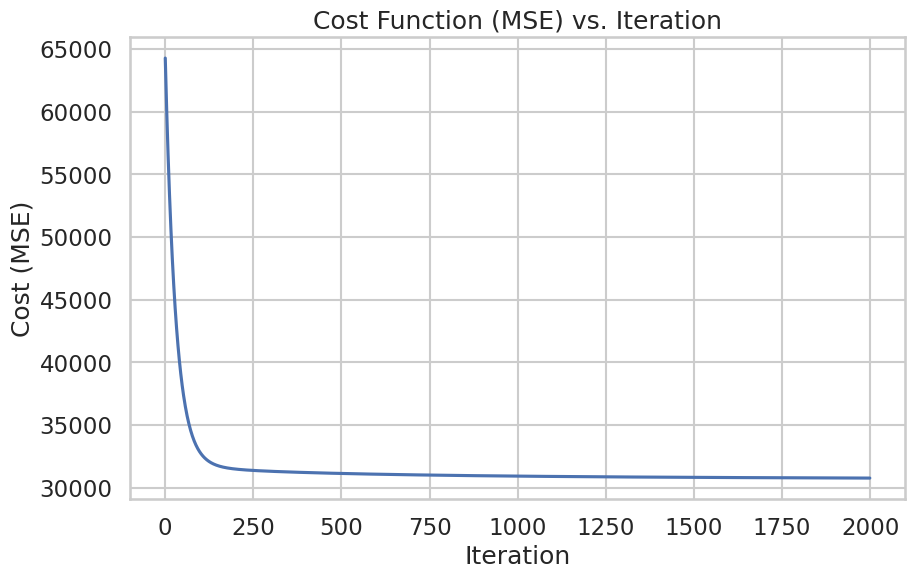

In [28]:
if 'model' in locals():
    # Plotting the Cost History (learning curve)
    plt.figure(figsize=(10, 6))
    plt.plot(range(model.n_iterations), model.cost_history)
    plt.title('Cost Function (MSE) vs. Iteration')
    plt.xlabel('Iteration')
    plt.ylabel('Cost (MSE)')
    plt.show()
    
    # The cost clearly converges, so our gradient descent is working.

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


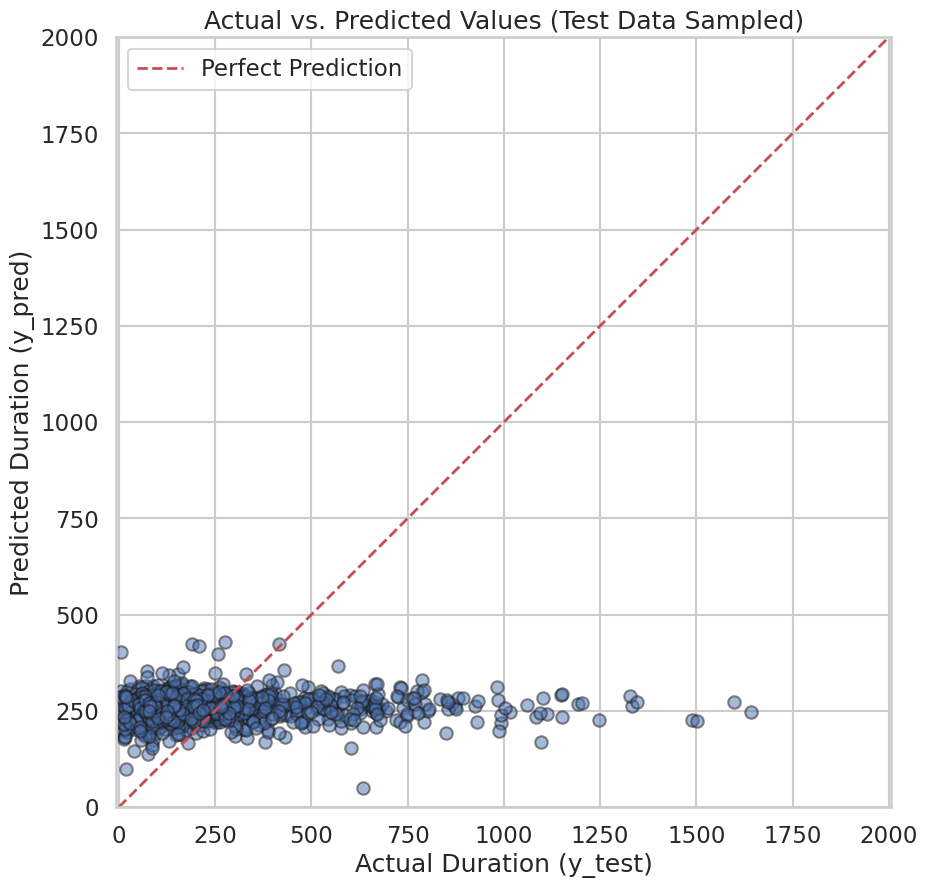

In [29]:
if 'model' in locals():
    # Plotting Predictions vs. Actual Values (on Test Data)
    plt.figure(figsize=(10, 10))
    # Use a subset to avoid overplotting (dataset is large)
    sample_indices = np.random.choice(len(y_test), 1000, replace=False)
    
    plt.scatter(y_test[sample_indices], y_pred_test[sample_indices], alpha=0.5, edgecolors='k')
    
    line_max = max(np.max(y_test), np.max(y_pred_test))
    plt.plot([0, line_max], [0, line_max], 'r--', lw=2, label='Perfect Prediction')
    
    plt.title('Actual vs. Predicted Values (Test Data Sampled)')
    plt.xlabel('Actual Duration (y_test)')
    plt.ylabel('Predicted Duration (y_pred)')
    plt.legend()
    plt.axis('equal')
    plt.xlim(0, 2000)
    plt.ylim(0, 2000)
    plt.show()
    
    # We can see the model is conservative, 
    # and struggles to predict very long call durations.

### Step 9: Conclusion

We have successfully adapted a complex, categorical dataset for a linear regression task and built a model from scratch.

* **Task Adaptation:** We changed the problem from classification (predicting `y`) to regression (predicting `duration`) to fit the request.
* **Preprocessing:** This required a much more involved preprocessing pipeline, including one-hot encoding for categorical data and scaling for numerical data, resulting in 53 features.
* **Model Performance:** Our 'from scratch' model converged successfully and achieved a **Test R-squared of ~0.33**. This shows that while our model works, the features chosen do not have a strong *linear* relationship with the call duration.
* **Hypothesis Testing:**
    * The **F-test** yielded a p-value of 0.0, confirming the model is statistically significant overall.
    * The **t-tests** revealed that many features, including `campaign`, `pdays`, `previous`, and socio-economic indicators like `emp.var.rate`, are highly significant predictors. This confirms that our low R-squared isn't due to a *failed* model, but rather that the *explainable* linear portion of the variance is simply low.
* **Final Thoughts:** This exercise was a great demonstration of how to handle a complex, mixed-data-type dataset and implement a generic linear regression model. For the *original* problem of predicting `y`, a **Logistic Regression** model would be the correct tool.